In [1]:
import string
import matplotlib.pyplot as plt
import scipy.stats as stats
from tqdm.notebook import tqdm  # only for convenience
from experiments import *

# Run experiment

In [2]:
LIFSORN, CF_eTOe = run_free(seedi=0)

Initialize neurons
Initialize synapses
Growth phase
Starting simulation at t=0. s for a duration of 0.4 ks
32.5104 s (8%) simulated in 1m 0s, estimated 11m 18s remaining.
64.1684 s (16%) simulated in 2m 0s, estimated 10m 28s remaining.
95.9706 s (23%) simulated in 3m 0s, estimated 9m 30s remaining.
127.6479 s (31%) simulated in 4m 0s, estimated 8m 32s remaining.
159.0001 s (39%) simulated in 5m 0s, estimated 7m 35s remaining.
190.5751 s (47%) simulated in 6m 0s, estimated 6m 36s remaining.
221.8567 s (55%) simulated in 7m 0s, estimated 5m 37s remaining.
253.2009 s (63%) simulated in 8m 0s, estimated 4m 38s remaining.
284.5628 s (71%) simulated in 9m 0s, estimated 3m 39s remaining.
315.7729 s (78%) simulated in 10m 0s, estimated 2m 40s remaining.
0.3470044 ks (86%) simulated in 11m 0s, estimated 1m 41s remaining.
0.3783046 ks (94%) simulated in 12m 0s, estimated 41s remaining.
0.4 ks (100%) simulated in 12m 41s
Analysis phase
Starting simulation at t=0.4 ks for a duration of 100. s
28.5

In [3]:
#LIFSORN.store(name="free", filename="./data/free")  # save data 

In [4]:
G_e, G_i, S_eTOe = LIFSORN.sorted_objects[:3]
MS_e, MS_i = LIFSORN.sorted_objects[10:12]
MW_eTOe = LIFSORN.sorted_objects[-2]

# Prepare data

In [5]:
# Helper funtion to get pairwise correlation coefficients
def get_ccs(MS, N):

    # Bin spikes
    bin_size = 20*ms
    bins = int(100*second/bin_size)
    spikes_count = np.zeros((N_e, bins))
    for i in range(N):
        spikes = MS.t[MS.i==i]-400*second
        for t_i in spikes:
            spikes_count[i, int(t_i/bin_size)] += 1

    # Pairwise CCs
    cc_list=[]
    for i in tqdm(range(N_e-1)):
        for j in range(i+1, N_e):
            cc_list.append(stats.pearsonr(spikes_count[i], spikes_count[j])[0])
    
    return cc_list

# Helper funtion to get interspike intervals
def get_isi(MS):
    isis = []
    cvs = []
    spiketrains = MS.spike_trains()
    for times in spiketrains.values():
        isis.append(np.diff(times/second))
        cvs.append(np.std(isis[-1]) / np.mean(isis[-1])) 
    return np.concatenate(isis), cvs

In [6]:
cc_list = get_ccs(MS_e, N_e)
isis, cvs = get_isi(MS_e)

# Figure 1

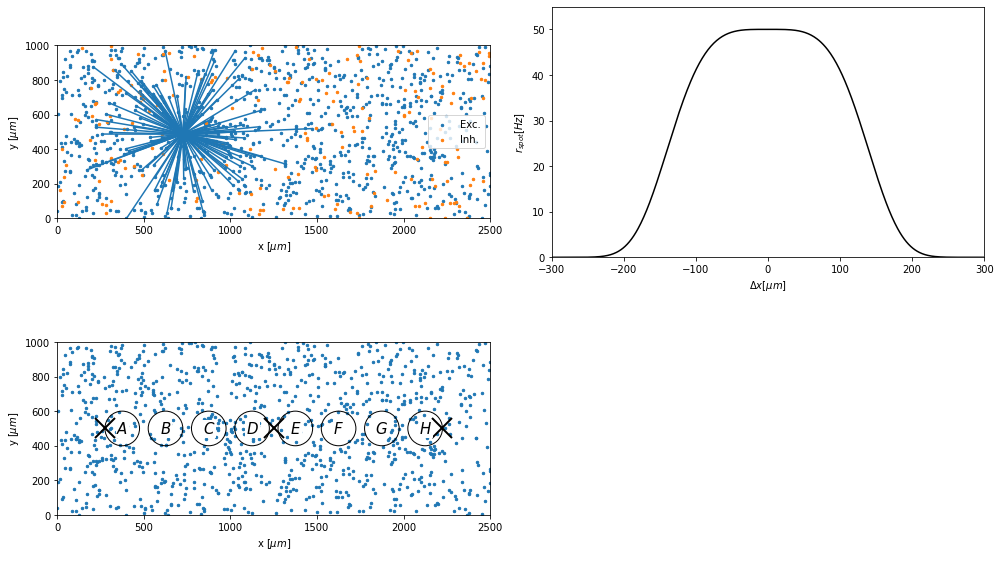

In [7]:
fig, axs = plt.subplots(2, 2, figsize=(14, 8))

# Panel A
ax = axs[0, 0]
ax.scatter(G_e.x/umeter, G_e.y/umeter, s=6, label="Exc.")
ax.scatter(G_i.x/umeter, G_i.y/umeter, s=6, label="Inh.")
x_0 = G_e.x[0]/umeter
y_0 = G_e.y[0]/umeter
for neur_pre in (np.where(S_eTOe.c[:, 0]==1)[0]+1):
    x_pre = G_e.x[neur_pre]/umeter
    y_pre = G_e.y[neur_pre]/umeter
    ax.plot([x_pre, x_0], [y_pre, y_0], c="C0")
ax.set_xlim(0, length_T/umeter)
ax.set_ylim(0, height_T/umeter)
ax.set_xlabel("x [$\mu m$]")
ax.set_ylabel("y [$\mu m$]")
ax.legend()
ax.set_aspect("equal")

# Panel B
ax = axs[0, 1]
xs = np.linspace(-300, 300, 601) * umeter
xs = np.tile(xs, (2, 1)).T
xs[:, 1] = 0*meter
ax.plot(xs[:,0]/umeter, spot_rate(xs, 0*umeter), c="k")
ax.set_xlim(-300, 300)
ax.set_ylim(0, 55)
ax.set_xlabel("$\Delta x [\mu m]$")
ax.set_ylabel("$r_{spot} [Hz]$")

# Panel C
ax = axs[1, 0]
ax.scatter(G_e.x/umeter, G_e.y/umeter, s=6)
for clu in range(clu_num):
    clu_center = clu_start + (clu_end-clu_start) * clu/(clu_num-1)
    clu_center /= umeter
    circle = plt.Circle((clu_center[0], clu_center[1]), 
                        radius=clu_r/umeter, fill=False)
    ax.text(clu_center[0], clu_center[1], 
                r"$%s$" % string.ascii_uppercase[clu], fontsize=15, 
                bbox=dict(color="w", alpha=1, pad=0.1), va="center", ha="center")
    ax.add_patch(circle)
ax.plot(spot_start[0]/umeter, spot_start[1]/umeter, "kx", ms=20, mew=2)
ax.plot(spot_end[0]/umeter, spot_end[1]/umeter, "kx", ms=20, mew=2)
ax.plot(spot_mid[0]/umeter, spot_mid[1]/umeter, "kx", ms=20, mew=2)
ax.set_xlim(0, length_T/umeter)
ax.set_ylim(0, height_T/umeter)
ax.set_xlabel("x [$\mu m$]")
ax.set_ylabel("y [$\mu m$]")
ax.set_aspect("equal")

axs[1,1].axis("off")

fig.tight_layout()
plt.show()

# Figure 2

## Panels A-D

In [8]:
# Helper function to plot spike trains
def plot_spikes(ax, MS, N, ylabel, c="C0"):
    ax.plot(MS.t, MS.i, '.', c=c)
    ax.set_ylim(0, N)
    ax.set_xlim(499, 500)
    ax.set_ylabel(ylabel)
    ax.set_xlabel("Simulation time [s]")

# Helper function to plot rate distribution
def plot_rates(ax, MS, N, c="C0", label="Exc."):
    rates = MS.count/(MS.t[-1]-MS.t[0])*second
    ax.hist(rates, color=c, bins=20)
    ax.legend([label])
    ax.set_ylabel("Count")
    ax.set_xlabel("Rate [Hz]")

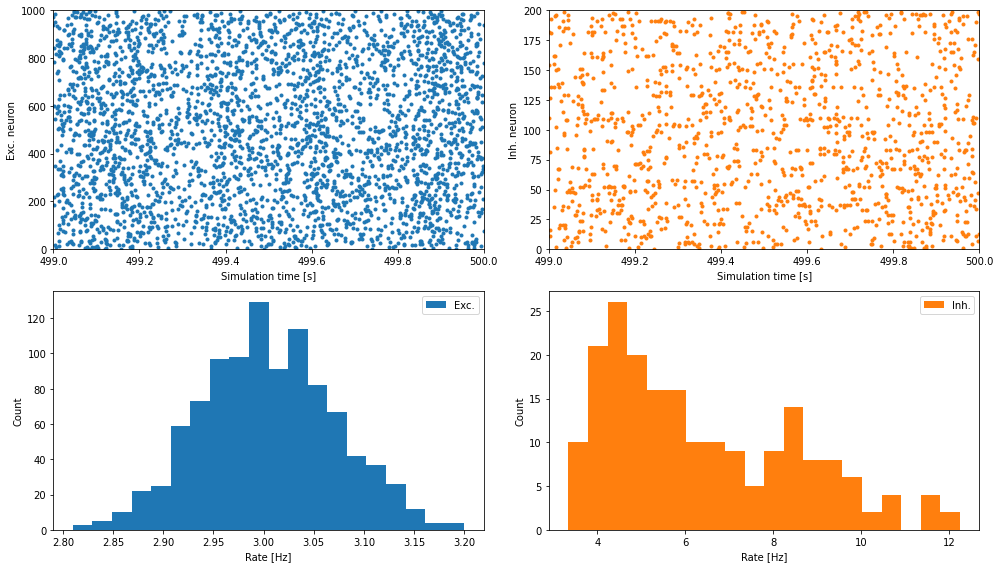

In [9]:
fig, axs = plt.subplots(2, 2, figsize=(14, 8))

# Panels A-D
plot_spikes(axs[0, 0], MS_e, N_e, "Exc. neuron")
plot_spikes(axs[0, 1], MS_i, N_i, "Inh. neuron", "C1")
plot_rates(axs[1, 0], MS_e, N_e)
plot_rates(axs[1, 1], MS_i, N_i, "C1", label="Inh.")

fig.tight_layout()
plt.show()

## Panels E-G

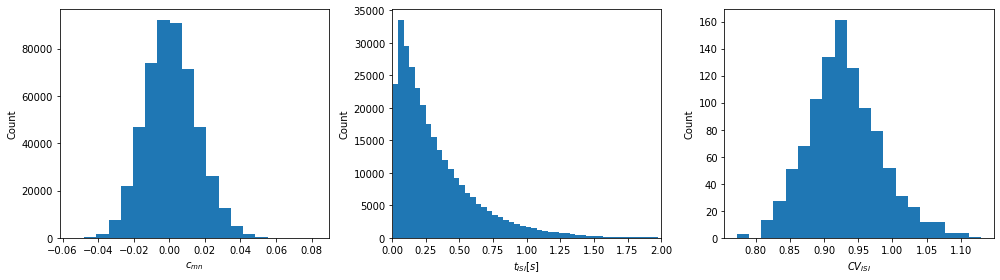

In [10]:
fig, axs = plt.subplots(1, 3, figsize=(14, 4))

# Panel E
ax = axs[0]
ax.hist(cc_list, bins=20)
ax.set_ylabel("Count")
ax.set_xlabel("$c_{mn}$")

# Panel F
ax = axs[1]
ax.hist(isis, bins=100)
ax.set_ylabel("Count")
ax.set_xlabel("$t_{ISI} [s]$")
ax.set_xlim(0, 2)

# Panel G
ax = axs[2]
ax.hist(cvs, bins=20)
ax.set_ylabel("Count")
ax.set_xlabel("$CV_{ISI}$")

fig.tight_layout()
plt.show()

# Figure 3

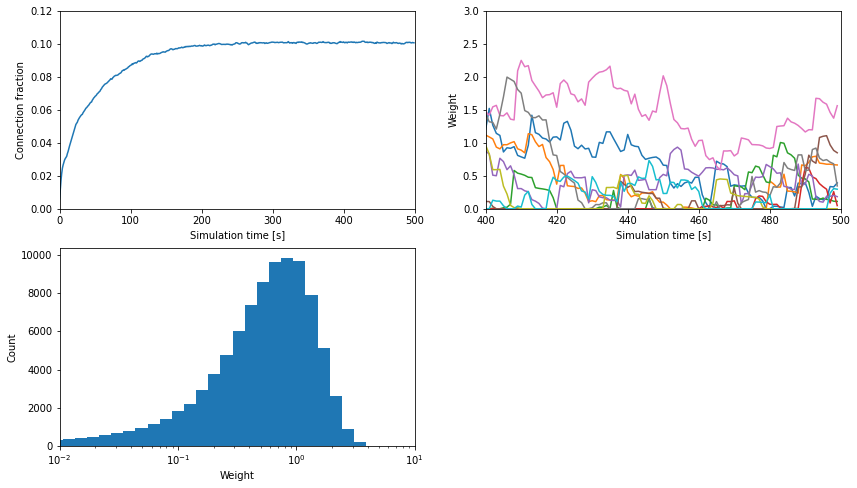

In [11]:
fig, axs = plt.subplots(2, 2, figsize=(14, 8))

# Panel A
ax = axs[0,0]
ax.plot(CF_eTOe)
ax.set_xlim(0, 500)
ax.set_ylim(0, 0.12)
ax.set_xlabel("Simulation time [s]")
ax.set_ylabel("Connection fraction")

# Panel B
ax = axs[0,1]
rng = np.random.default_rng(53111)
ax.plot(MW_eTOe.t, MW_eTOe.w[rng.choice(np.arange(1_000), 10, replace=False)].T)
ax.set_xlim(400, 500)
ax.set_ylim(0, 3)
ax.set_xlabel("Simulation time [s]")
ax.set_ylabel("Weight")

# Panel C
ax = axs[1,0]
logbins = np.logspace(np.log10(0.001), np.log10(10), 40)
ax.hist(S_eTOe.w[:][S_eTOe.c[:]==1], bins=logbins)
ax.set_xscale("log")
ax.set_xlim(1e-2, 1e1)
ax.set_xlabel("Weight")
ax.set_ylabel("Count")

axs[1,1].axis("off")

plt.show()